# Output of SMICA fit and compare to input data
This notebook is for the DX12 / NPIPE / NPIPE_sim results of the paper
## Header

In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os, sys
import json
import matplotlib.gridspec as gridspec
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from healpy.sphtfunc import smoothing
import smica
import copy
from astropy.io import fits
from scipy import interpolate

import component_separation.transformer as trsf
import component_separation.map as mp
from component_separation.cs_util import Config
from component_separation.cs_util import Smica_bins as const
from component_separation.io import IO
import component_separation.powerspectrum as pospec
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Filename_gen as fn_gen
from component_separation.cs_util import Filename_gen_SMICA as fns_gen

import component_separation.MSC.MSC.apodize as ap

import component_separation.smica_interface as smint
import component_separation.map as mp
import component_separation.covariance as cv
# apodized = ap.apodize_planck(hp.ud_grade(pmask['100'], nside_out=2048))

csu = Config(freqdset='DX12', mskset='smica', spectrum_type='pseudo')
io = IO(csu)
fn = fn_gen(csu)
colors = csu.CB_color_cycle
fns = fns_gen(csu)

apo = csu.spectrum_type == 'pseudo'
lmax_loc = csu.lmax
bins = csu.bins
TEB = 1
simid = -1
lmaxbins = int(bins[-1][1])
colors = csu.CB_color_cycle
Tscale = "K_CMB"

In [7]:
tmask_fn = fn.get_mask('T', apodized=apo)
pmask_fn = fn.get_mask('P', apodized=apo)
tmask_sg = io.load_mask(tmask_fn)
pmask_sg = io.load_mask(pmask_fn)
tmask, pmask = dict(), dict()
for FREQ in csu.FREQ:
    if FREQ not in csu.FREQFILTER:
        tmask[FREQ] = tmask_sg
        pmask[FREQ] = pmask_sg
beam5 = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,1]
beamf = io.load_beamf(csu.freqcomb, csu.lmax, csu.freqdatsplit)

spectrum_truth = io.load_truthspectrum()
spectrum_truth.shape

mapTc_fn = fns.get_map('T', 'combined', simid=simid)
mapTc = np.load(mapTc_fn)
mapTcs_fn = fns.get_map('T', 'combined', simid=simid)
mapTcs = np.load(mapTcs_fn.replace('.', 'smoothed.'))
ClTc = np.load(fns.get_spectrum('T', 'combined', simid=simid))

In [8]:
maq_lpDXS = hp.smoothing(hp.ma(mpjc[1]), np.radians(1))
mau_lpDXS = hp.smoothing(hp.ma(mpjc[2]), np.radians(1))
mpjcs = np.array([np.zeros_like(maq_lpDXS), maq_lpDXS, mau_lpDXS])

# SMICA input and ouptput
Config.json specific
## Header

In [3]:
Cltot = io.load_data(fn.get_spectrum("T", "non-separated", simid=-1))
covltot = cv.build_covmatrices(Cltot, Tscale, csu.freqcomb, csu.FREQ_f, csu.cutoff_freq, 1100)

ClN = io.load_data(fn.get_spectrum("N", "non-separated", simid=-1))
covlN = cv.build_covmatrices(ClN, Tscale, csu.freqcomb, csu.FREQ_f, csu.cutoff_freq, 1100)

ClS = io.load_data(fns.get_spectrum("S", "non-separated", simid=-1))
covlS = cv.build_covmatrices(ClS, Tscale, csu.freqcomb, csu.FREQ_f, csu.cutoff_freq, 1100)

smica_params = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
for k, v in smica_params.items():
    smica_params[k] = io.load_data(fns.get_misc(k))

Clmin = io.load_data(fns.get_spectrum("T", "combined", simid=-1))

Mapmin = io.load_data(fns.get_map("T", "combined", simid=-1))
Mapmin_smoothed = io.load_data(fns.get_map("T", "combined", simid=-1).replace('.', 'smoothed.'))
# tf = io.load_data(io.fh.out_misc_path+"tf_{}".format(csu.binname) + "_" + filename)
# hist = io.load_data(io.fh.out_specsmica_path+"hist_{}".format(csu.cf['pa']['binname']) + "_" + io.fh.total_filename)

loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/ClT_non-separated_2048_4000_pseudo.npy
(6, 7, 7, 4001)
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/ClN_non-separated_2048_4000_pseudo.npy
(6, 7, 7, 4001)
loaded /global/cscratch1/sd/sebibel/compsep/planck/Sest/ClS_NPIPEsim.npy
(6, 7, 7, 4001)
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_cov_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_cov4D_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_CMB_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_gal_mm_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_w_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/ClT_combined_SMICA_highell_bins_2048_4000_pseudo.npy
loaded /global/cs

In [4]:
covltot_bnd = hpf.bin_it(covltot[TEB], bins=bins)
covlN_bnd = hpf.bin_it(covlN[TEB], bins=bins)
covlN_bnd = np.diagonal(covlN_bnd, axis1=0, axis2=1).T
covlS_bnd =  hpf.bin_it(covlS[TEB], bins=bins)

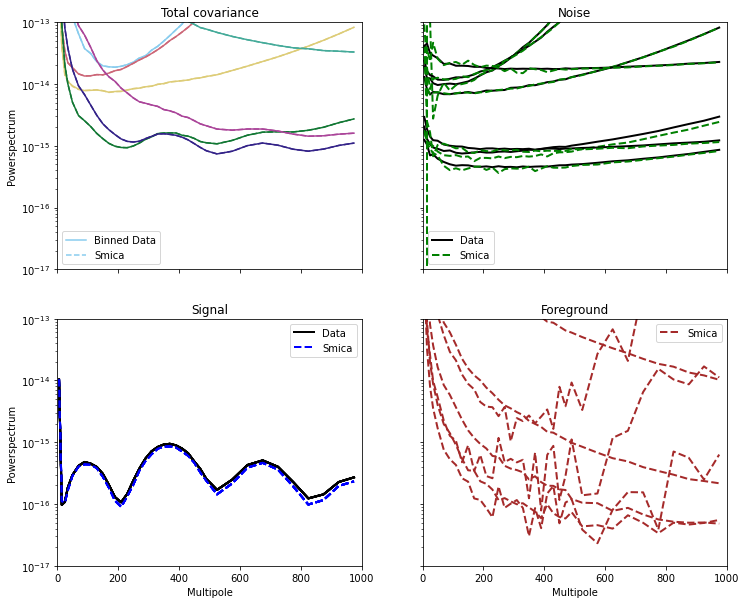

In [5]:
#%matplotlib widget
fig, axs = plt.subplots(2,2, figsize=(12,10), sharex=True,  sharey=True)
def logi(a, b):
    return a==b# and a>=3 and b>=3
ax=axs[0,0]
ax.set_title('Total covariance')
ax.set_yscale('log')
ax.set_ylabel('Powerspectrum')
ax.set_xlim((0,1000))
ax.set_ylim((1e-17,1e-13))
lab1 = 'Binned Data'
lab3 = 'Data'
lab2 = 'Smica'
for n in range(covltot_bnd.shape[1]):
    for m in range(covltot_bnd.shape[1]):
        if logi(n, m):# and n<3 and m<3:
            if n==m:
                ax.plot(np.mean(bins, axis=1), smica_params['cov'][TEB-1,n,m,:], label=lab1, color=colors[n])
                ax.plot(np.mean(bins, axis=1), covltot_bnd[n,m,:], label=lab2, color=colors[n], ls='--')
            else:
                ax.plot(np.mean(bins, axis=1), covltot_bnd[n,m,:], label=lab1, color=colors[n])
            lab1 = None
            lab2 = None
            lab3 = None
ax.legend()

ax=axs[0,1]
ax.set_title('Noise')
ax.set_yscale('log')
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(covlN.shape[1]):
    for m in range(covltot_bnd.shape[1]):
         if logi(n, m):
            if n==m:
                ax.plot(np.mean(bins, axis=1), covlN_bnd[n,:], color= 'black', lw=2, label=lab1)
                ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,2], color= 'green', lw=2, label=lab2, ls='--')
                lab1 = None
                lab2 = None
                ax.legend()         
            else:
                ax.text(lmaxbins-100, 1e0, 'Noise diagonal')

ax=axs[1,0]
ax.set_title('Signal')
ax.set_xlabel('Multipole')
ax.set_yscale('log')
ax.set_ylabel('Powerspectrum')
ax.set_ylim((1e-17, 1e-13))
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(covlS_bnd.shape[0]):
    for m in range(covlS_bnd.shape[1]):
        if logi(n, m):
            ax.plot(np.mean(bins, axis=1), covlS_bnd[n,m,:], color= 'black', lw=2, label=lab1)
            ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,0], color= 'blue', lw=2, label=lab2, ls='--')
            lab1 = None
            lab2 = None
ax.legend()

ax=axs[1,1]
ax.set_title('Foreground')
ax.set_xlabel('Multipole')
ax.set_yscale('log')
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(smica_params['cov4D'].shape[1]):
    for m in range(smica_params['cov4D'].shape[2]):
        if logi(n, m):
            ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,1], color= 'brown', lw=2, label=lab2, ls='--')
            lab1 = None
            lab2 = None
ax.legend()

Text(0.5, 1.0, 'Noise amplitude change in SMICA fit')

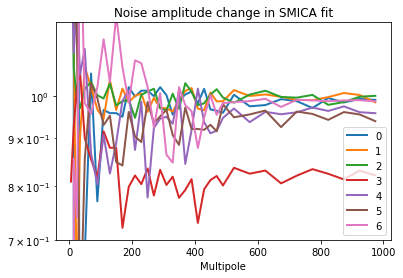

In [6]:
for n in range(covlN.shape[1]):
    for m in range(covltot_bnd.shape[1]):
         if logi(n, m):
            if n==m:
                plt.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,2]/covlN_bnd[n,:], lw=2, label=n, alpha=1.0)
                lab1 = None
                lab2 = None
                plt.legend()
plt.yscale('log')
plt.ylim((0.7,1.2))
plt.xlabel('Multipole')
plt.title('Noise amplitude change in SMICA fit')

In [7]:
W_mv = io.load_data(fn.get_misc('w', simid=simid))
W_smica = io.load_data(fns.get_misc('w', simid=simid))
W_total = hpf.interp_smica_mv_weights(W_smica, W_mv, bins, 4001)
W_total[:,:,0:2] = 0.0

W_total_propag = np.loadtxt("/global/homes/s/sebibel/ext/smica_propagation/weights_EB_smica_R3.00.txt").reshape(2,7,4001)

loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/w_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_w_SMICA_highell_bins_pseudo.npy


## Compare to 2018 SMICA DX12 release

In [6]:
mpjc = hp.read_map('/project/projectdirs/cmb/data/planck2018/pr3/cmbmaps/dx12_v3_smica_cmb_005a_2048.fits', field=(0,1,2))
cljc = trsf.map2cl_ss(mpjc[1:], pmask, 2, 2500, 3000)
# apodized2048 = ap.apodize_planck(hp.ud_grade(pmask['100'], nside_out=2048))
# mpjcfast = np.array([hp.anafast([n * apodized2048 for n in mpjc],lmax=1500)])
mpjcfast = np.array([hp.anafast([n * pmask['100'] for n in mpjc],lmax=2500)])

NameError: name 'pmask' is not defined

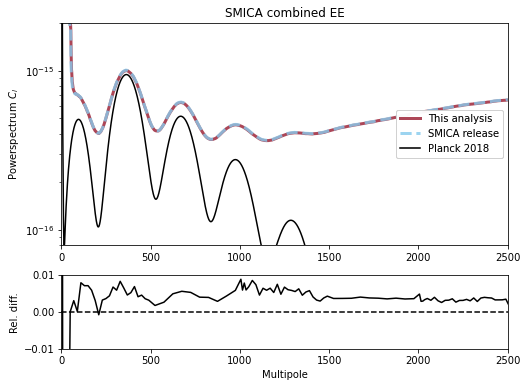

--


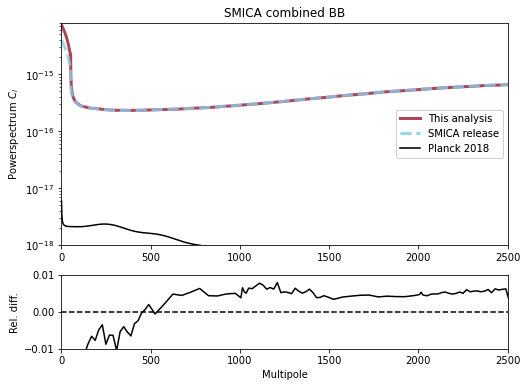

--


In [188]:
from scipy.signal import savgol_filter as sf
colorsl = csu.CB_color_cycle_lighter 
if apo:
    cljc_loc = mpjcfast
else:
    cljc_loc = cljc
for itn, n in enumerate(['EE', 'BB']):
    plt.figure(figsize=(8,6))
    ll = np.arange(lmax_loc)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    ax0.plot(sf(ClTc[0,itn+1],101,1), label='This analysis'.format(n), color=colorsl[1], lw=3)
    ax0.plot(sf(cljc_loc[0,itn+1],101,1), label='SMICA release'.format(n), color=colors[0], lw=3, ls='--', alpha=0.8)
    
    ax0.plot(spectrum_truth['Planck-{}'.format(n)].to_numpy()[:lmax_loc]*1e-12/(ll*(ll+1)/(2*np.pi)), label= 'Planck 2018'.format(n), color='black')

    leg1 = ax0.legend(loc='center right')
    # leg2 = ax0.legend([soliddummy,dasheddummy],['This analysis','SMICA DX12 2018 release'], loc='upper right')
    ax0.add_artist(leg1)

    ax1.hlines(0,0,2550, color='black', ls='--')
    longbins = np.concatenate((bins,1000+bins,2000+bins))
    ax1.plot(np.mean(longbins,axis=1), sf(hpf.bin_it1D(cljc_loc[0,itn+1,:2500]/ClTc[0,itn+1,:2500]-1,bins=longbins),3,2), label='', color='black')
    
    ax0.set_title("SMICA combined {}".format(n))
    ax0.set_yscale('log')
    ax0.set_xlim((0,2500))
    if itn==0:
        ax0.set_ylim((8e-17,2e-15))
    else:
        ax0.set_ylim((1e-18,8e-15))
    ax0.set_ylabel(r"Powerspectrum $C_l$")
    
    ax1.set_xlabel('Multipole')
    ax1.set_ylabel('Rel. diff.')
    ax1.set_ylim((-0.01,0.01))
    ax1.set_xlim((0,2500))
    plt.show()
    print('--')

## Weights

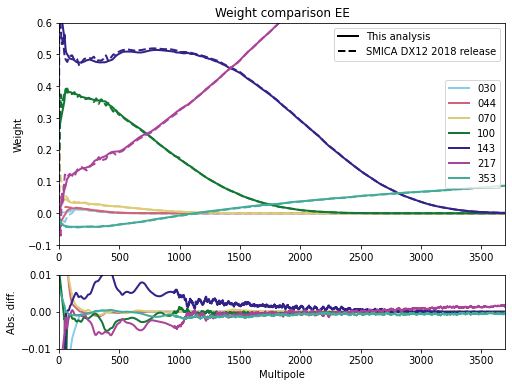

---


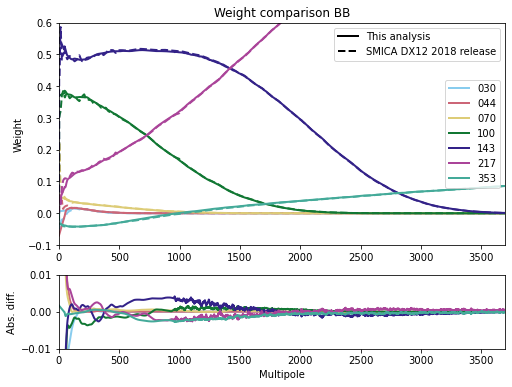

---


In [91]:
from scipy.signal import savgol_filter as sf
for itn, n in enumerate(['EE','BB']):
    plt.figure(figsize=(8,6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    soliddummy, = plt.plot(0,0,ls='-', color='black', lw=2)
    dasheddummy, = plt.plot(0,0,ls='--', color='black', lw=2)
    for freq in range(7):
        ax0.plot(sf(W_total[itn+1,freq],91,1), color=colors[freq], label=csu.FREQ_f[freq], lw=2)
        ax0.plot(W_total_propag[itn][freq]*hp.pixwin(2048)[:4001]/hp.gauss_beam(np.radians(5/60), 4000, pol = True)[:,1]*np.nan_to_num(beamf[1,freq,freq]), color=colors[freq], ls='--', lw=2)
        ax1.plot(sf(W_total_propag[itn][freq]*hp.pixwin(2048)[:4001]/hp.gauss_beam(np.radians(5/60), 4000, pol = True)[:,1]*np.nan_to_num(beamf[1,freq,freq])-W_total[itn+1,freq],91,1), color=colors[freq], lw=2)

    leg1 = ax0.legend(loc='center right')
    leg2 = ax0.legend([soliddummy,dasheddummy],['This analysis','SMICA DX12 2018 release'], loc='upper right')
    ax0.add_artist(leg1)
    ax0.set_title('Weights {}'.format(n))
    ax0.set_xlim((0,3700))

    ax0.set_ylabel('Weight')
    ax0.set_ylim((-0.1,0.6))
    ax1.set_xlabel('Multipole')
    ax1.set_ylabel('Abs. diff.')
    ax1.set_ylim((-0.01,0.01))
    ax1.set_xlim((0,3700))
    plt.show()
    print('---')

In [4]:
from component_separation.config_planck import Lens_Mask as LM
from component_separation.config_planck import Smica_Mask as SM

Tmask_LMfn = [os.path.join(LM.get_dir(), fn) 
    for fn in LM.get_fn("T")]
Pmask_LMfn = [os.path.join(LM.get_dir(), fn) 
    for fn in LM.get_fn("P")]

Tmask_SMfn = [os.path.join(SM.get_dir(), fn) 
    for fn in LM.get_fn("T")]
Pmask_SMfn = [os.path.join(SM.get_dir(), fn) 
    for fn in SM.get_fn("P")]

Tmask_LM = io.load_mask(Tmask_LMfn, stack=True)
Pmask_LM = io.load_mask(Pmask_LMfn, stack=True)

Tmask_SM = io.load_mask(Tmask_SMfn, stack=True)
Pmask_SM = io.load_mask(Pmask_SMfn, stack=True)

csuDS = Config(freqdset='DX12', mskset='smica', spectrum_type='pseudo', verbose=False)
fnDS= fn_gen(csuDS)
fnsDS = fns_gen(csuDS)

mapC_DS = io.load_data(fnsDS.get_map('T', 'combined'))
ClC_DS = io.load_data(fnsDS.get_spectrum('T', 'combined'))

loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/MapT_combined_SMICA_highell_bins_2048_4000_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/ClT_combined_SMICA_highell_bins_2048_4000_pseudo.npy


In [ ]:
csuNL = Config(freqdset='NPIPE', mskset='lens', spectrum_type='pseudo', verbose=False)
fnNL= fn_gen(csuNL)
fnsNL = fns_gen(csuNL)

mapC_NL = io.load_data(fnsNL.get_map('T', 'combined'))
ClC_NL = io.load_data(fnsNL.get_spectrum('T', 'combined'))

In [5]:
hp.mollview(mpjc[1], norm='hist', title='SMICA DX12 2018 release')
hp.mollview(mapTc[1], norm='hist', title='This analysis')

NameError: name 'mpjc' is not defined

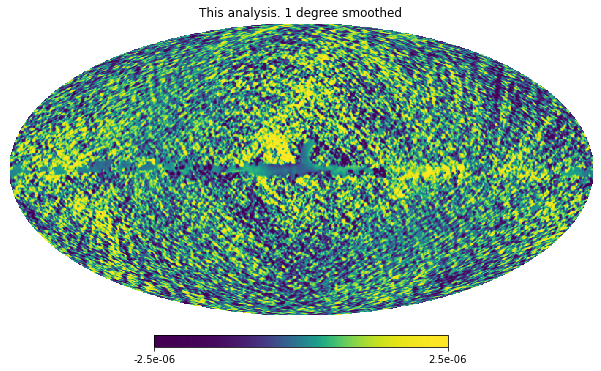

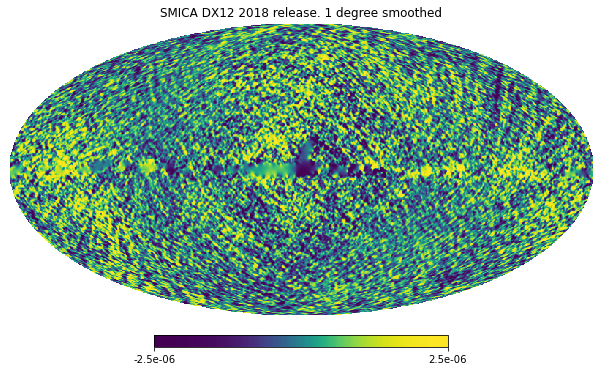

In [9]:
hp.mollview(mapTcs[2], norm='hist', min=-2.5*1e-6, max=2.5*1e-6, title='This analysis. 1 degree smoothed')
hp.mollview(mpjcs[2], norm='hist', min=-2.5*1e-6, max=2.5*1e-6, title='SMICA DX12 2018 release. 1 degree smoothed')

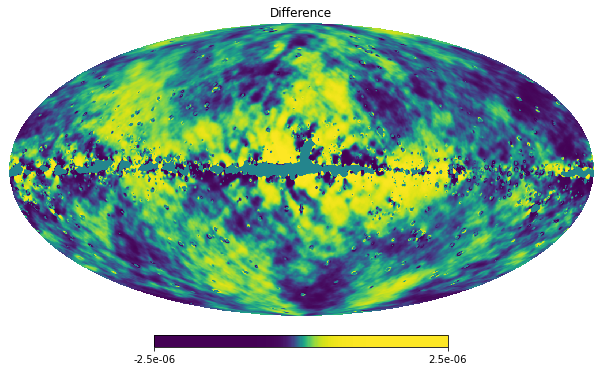

In [10]:
hp.mollview(mapTcs[2]*pmask_sg-mpjcs[2]*pmask_sg, min=-2.5*1e-6, max=2.5*1e-6, title='Difference', norm='hist', xsize=1600)

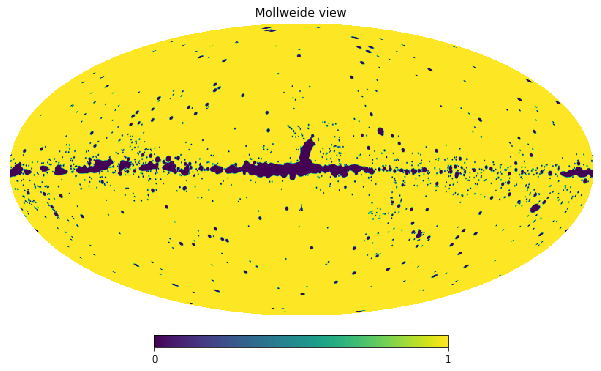